<a href="https://www.kaggle.com/code/karahanos/pre-snap-game-prediction?scriptVersionId=207938190" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Pre-Snap Game Prediction!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, cross_validate
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.utils import compute_class_weight
from category_encoders import BinaryEncoder
from xgboost import XGBClassifier
import xgboost as xgb

import optuna
# Set the verbosity level to 0 (no output)
optuna.logging.set_verbosity(optuna.logging.CRITICAL)

import warnings
warnings.filterwarnings('ignore')


# Function to drop unwanted features from the dataset
def drop_unwanted_features(df, features_to_drop):
    """
    Drops specified features (columns) from the DataFrame.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame.
    features_to_drop (list): List of column names to drop.
    
    Returns:
    pd.DataFrame: A new DataFrame with the specified columns dropped.
    """
    # Check if all columns to drop exist in the DataFrame
    features_to_drop = [feature for feature in features_to_drop if feature in df.columns]
    
    # Drop the unwanted features
    df_cleaned = df.drop(columns=features_to_drop)
    
    return df_cleaned
    # Returns a DataFrame without the unwanted columns

# Function to convert game clock time into seconds
def convert_to_seconds(game_clock):
    """
    Converts the game clock time (in 'MM:SS' format) to seconds.
    
    Parameters:
    game_clock (str): The game clock time as a string in 'MM:SS' format.
    
    Returns:
    int: The game clock time converted into seconds.
    """
    # Split the clock string into minutes and seconds and convert to integers
    minutes, seconds = map(int, game_clock.split(':'))
    
    # Convert the time into total seconds
    return minutes * 60 + seconds

# Function to calculate remaining time till the end of the half
def calculate_remaining_time_end_of_half(row):
    """
    Calculates the remaining time in seconds until the end of the half based on the game clock and half number.
    
    Parameters:
    row (pd.Series): A row of the DataFrame containing 'gameClock' and 'half' columns.
    
    Returns:
    int: The remaining time in seconds until the end of the half.
    """
    half_game_time = 30 * 60  # 1800 seconds in a half (30 minutes * 60 seconds)
    
    # Convert the game clock to seconds for the current row
    quarter_time_remaining = convert_to_seconds(row['gameClock'])
    
    # Calculate the total elapsed time in the game up to the current quarter
    # Half 1 includes the first two quarters (each 15 minutes or 900 seconds), so we account for that
    elapsed_time = (row['half'] - 1) * 900 + (900 - quarter_time_remaining)
    
    # Remaining time until the end of the half
    return half_game_time - elapsed_time


### Initial Data Understanding and Cleaning

In [2]:
plays_df = pd.read_csv(r'/kaggle/input/nfl-big-data-bowl-2025/plays.csv')
games_df = pd.read_csv(r'/kaggle/input/nfl-big-data-bowl-2025/games.csv')


In [3]:
plays_df.sample(5)

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,...,yardsGained,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded,expectedPointsAdded,isDropback,pff_runConceptPrimary,pff_runConceptSecondary,pff_runPassOption,pff_passCoverage,pff_manZone
7463,2022102300,2194,(7:05) N.Chubb left tackle to CLV 36 for 6 yar...,3,2,5,CLE,BAL,CLE,30,...,6,-0.013785,0.013785,0.808024,False,OUTSIDE ZONE,NaN,0,Cover-3,Zone
8943,2022100905,193,(11:18) D.Skipper reported in as eligible. Ja...,1,4,1,DET,NE,DET,45,...,0,0.048489,-0.048489,-3.593077,False,FB RUN,NaN,0,Cover-1,Man
97,2022091811,120,(13:00) J.Jacobs up the middle to 50 for 6 yar...,1,1,10,LV,ARI,LV,44,...,6,0.003487,-0.003487,0.086784,False,TRAP,LEAD,0,Cover-2,Zone
14446,2022102300,409,(6:23) (Shotgun) K.Drake right guard to BLT 48...,1,1,10,BAL,CLE,BAL,44,...,4,-0.004950,0.004950,-0.121670,False,POWER,LEAD,0,Quarters,Zone
3349,2022100901,735,(3:34) (Shotgun) J.Allen left end to PIT 17 fo...,1,2,10,BUF,PIT,PIT,18,...,1,-0.003196,0.003196,-0.736739,False,OUTSIDE ZONE,LEAD;QB RUNS,0,Cover-3,Zone


As we see this dataframe contains various data about plays as descriptive, post-snap or pre-snap. Since we investigate a pre-snap incident we could drop irrelevant features like playDescription.   

In [4]:
plays_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16124 entries, 0 to 16123
Data columns (total 50 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   gameId                            16124 non-null  int64  
 1   playId                            16124 non-null  int64  
 2   playDescription                   16124 non-null  object 
 3   quarter                           16124 non-null  int64  
 4   down                              16124 non-null  int64  
 5   yardsToGo                         16124 non-null  int64  
 6   possessionTeam                    16124 non-null  object 
 7   defensiveTeam                     16124 non-null  object 
 8   yardlineSide                      15900 non-null  object 
 9   yardlineNumber                    16124 non-null  int64  
 10  gameClock                         16124 non-null  object 
 11  preSnapHomeScore                  16124 non-null  int64  
 12  preS

In [5]:
games_df.sample(5)

,gameId,season,week,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr,homeFinalScore,visitorFinalScore
12,2022091112,2022,1,9/11/2022,16:25:00,MIN,GB,23,7
72,2022100907,2022,5,10/9/2022,13:00:00,NYJ,MIA,40,17
98,2022102303,2022,7,10/23/2022,13:00:00,DAL,DET,24,6
75,2022100910,2022,5,10/9/2022,16:05:00,CAR,SF,15,37
52,2022100204,2022,4,10/2/2022,13:00:00,DAL,WAS,25,10


In [6]:
plays_df.columns

Index(['gameId', 'playId', 'playDescription', 'quarter', 'down', 'yardsToGo',
       'possessionTeam', 'defensiveTeam', 'yardlineSide', 'yardlineNumber',
       'gameClock', 'preSnapHomeScore', 'preSnapVisitorScore',
       'playNullifiedByPenalty', 'absoluteYardlineNumber',
       'preSnapHomeTeamWinProbability', 'preSnapVisitorTeamWinProbability',
       'expectedPoints', 'offenseFormation', 'receiverAlignment',
       'playClockAtSnap', 'passResult', 'passLength', 'targetX', 'targetY',
       'playAction', 'dropbackType', 'dropbackDistance', 'passLocationType',
       'timeToThrow', 'timeInTackleBox', 'timeToSack', 'passTippedAtLine',
       'unblockedPressure', 'qbSpike', 'qbKneel', 'qbSneak',
       'rushLocationType', 'penaltyYards', 'prePenaltyYardsGained',
       'yardsGained', 'homeTeamWinProbabilityAdded',
       'visitorTeamWinProbilityAdded', 'expectedPointsAdded', 'isDropback',
       'pff_runConceptPrimary', 'pff_runConceptSecondary', 'pff_runPassOption',
       'pff_pass

In [7]:
games_df.columns

Index(['gameId', 'season', 'week', 'gameDate', 'gameTimeEastern',
       'homeTeamAbbr', 'visitorTeamAbbr', 'homeFinalScore',
       'visitorFinalScore'],
      dtype='object')

In [8]:
df = plays_df.merge(games_df[['gameId','homeTeamAbbr', 'visitorTeamAbbr']], on='gameId', how='left')# Merged two data set on gameIds

I've merged the two data-set for is possesion team whether leading or not

In [9]:
df.columns

Index(['gameId', 'playId', 'playDescription', 'quarter', 'down', 'yardsToGo',
       'possessionTeam', 'defensiveTeam', 'yardlineSide', 'yardlineNumber',
       'gameClock', 'preSnapHomeScore', 'preSnapVisitorScore',
       'playNullifiedByPenalty', 'absoluteYardlineNumber',
       'preSnapHomeTeamWinProbability', 'preSnapVisitorTeamWinProbability',
       'expectedPoints', 'offenseFormation', 'receiverAlignment',
       'playClockAtSnap', 'passResult', 'passLength', 'targetX', 'targetY',
       'playAction', 'dropbackType', 'dropbackDistance', 'passLocationType',
       'timeToThrow', 'timeInTackleBox', 'timeToSack', 'passTippedAtLine',
       'unblockedPressure', 'qbSpike', 'qbKneel', 'qbSneak',
       'rushLocationType', 'penaltyYards', 'prePenaltyYardsGained',
       'yardsGained', 'homeTeamWinProbabilityAdded',
       'visitorTeamWinProbilityAdded', 'expectedPointsAdded', 'isDropback',
       'pff_runConceptPrimary', 'pff_runConceptSecondary', 'pff_runPassOption',
       'pff_pass

In [10]:
features_to_drop = ['gameId','playId','isDropback', 'expectedPointsAdded', 'yardsGained', 'visitorTeamWinProbilityAdded',                    'homeTeamWinProbabilityAdded','prePenaltyYardsGained','penaltyYards','rushLocationType','qbSneak',                    'qbKneel','qbSpike','unblockedPressure','passTippedAtLine','timeToSack','timeInTackleBox','timeToThrow',                    'passLocationType','dropbackDistance','dropbackType','playAction','targetX', 'targetY','passLength',                    'playClockAtSnap', 'expectedPoints','preSnapVisitorTeamWinProbability','preSnapHomeTeamWinProbability',                    'playNullifiedByPenalty','yardlineSide','yardlineNumber','playDescription','pff_manZone','pff_passCoverage',                    'pff_runPassOption','pff_runConceptSecondary','pff_runConceptPrimary'] 

In here I've droped unnecessary columns for prediction

In [11]:
df_cleaned = drop_unwanted_features(df,features_to_drop)

In [12]:
df_cleaned.sample(5)

,quarter,down,yardsToGo,possessionTeam,defensiveTeam,gameClock,preSnapHomeScore,preSnapVisitorScore,absoluteYardlineNumber,offenseFormation,receiverAlignment,passResult,homeTeamAbbr,visitorTeamAbbr
13900,3,1,10,DEN,LV,09:14,19,16,59,WILDCAT,2x2,NaN,LV,DEN
10173,2,2,11,JAX,LAC,01:21,7,13,99,SHOTGUN,3x1,I,LAC,JAX
8336,3,1,10,NE,GB,08:07,14,10,60,I_FORM,2x1,NaN,GB,NE
12528,3,2,5,JAX,IND,01:49,17,0,19,SHOTGUN,3x1,NaN,JAX,IND
14694,3,1,18,TEN,NYG,07:17,13,13,55,SINGLEBACK,2x2,C,TEN,NYG


In [13]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16124 entries, 0 to 16123
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   quarter                 16124 non-null  int64 
 1   down                    16124 non-null  int64 
 2   yardsToGo               16124 non-null  int64 
 3   possessionTeam          16124 non-null  object
 4   defensiveTeam           16124 non-null  object
 5   gameClock               16124 non-null  object
 6   preSnapHomeScore        16124 non-null  int64 
 7   preSnapVisitorScore     16124 non-null  int64 
 8   absoluteYardlineNumber  16124 non-null  int64 
 9   offenseFormation        15936 non-null  object
 10  receiverAlignment       15936 non-null  object
 11  passResult              9736 non-null   object
 12  homeTeamAbbr            16124 non-null  object
 13  visitorTeamAbbr         16124 non-null  object
dtypes: int64(6), object(8)
memory usage: 1.7+ MB


## Feature Creation

/kaggle/input/nfl-big-data-bowl-2025/games.csvI have tried to create my features in scope of situational football:- Is my team behind? I would tend to play because I would tie the fame asap.- Is my team needs to hurry for a TD because we are behind and run out of time?- Are we leading and inside last two mins? I would tend to run the ball because I gotta melt time.  

In [14]:
# Half feature created 
df_cleaned['half'] = df_cleaned['quarter'].apply(lambda row: 1 if row < 3 else 2)
# Remaing time feature created
df_cleaned.loc[:, 'remainingTime'] = df_cleaned.apply(calculate_remaining_time_end_of_half, axis=1)

# df_cleaned dataset score data store as preSnapHomeScore and preSnapVisitor but team stored as possesionTeam and defensiveTeam.    

df_cleaned['possessionTeamScore'] = df_cleaned.apply(lambda row: row['preSnapHomeScore'] if row['possessionTeam'] == row['homeTeamAbbr'] else row['preSnapVisitorScore'], axis=1)
  
df_cleaned['defensiveTeamScore'] = df_cleaned.apply(lambda row: row['preSnapVisitorScore'] if row['possessionTeam'] == row['homeTeamAbbr'] else row['preSnapHomeScore'], axis=1)

# So I converted preSnapHomeScore and preSnapVisitor data to possessionTeamScore and defensiveTeamScore.
# This feature shows how many yards left for TD
df_cleaned['yardsToTd'] = df_cleaned['absoluteYardlineNumber'] - 10
df_cleaned['possessionTeamLeadsBy'] = df_cleaned['possessionTeamScore'] - df_cleaned['defensiveTeamScore']
df_cleaned['isPossessionTeamLead'] = df_cleaned.apply(lambda row: 0 if row['possessionTeamLeadsBy'] > 0 else 1, axis=1 )
df_cleaned['isPossessionTeamLead'] = df_cleaned['isPossessionTeamLead'].astype('byte')
# This feature is bytes variable that show the game wheter game is pass (1) or not (0) 
df_cleaned['WasItPass'] = df_cleaned['passResult'].apply(lambda row: 0 if pd.isnull(row) == True else 1)


In [15]:
# Half feature created 
df_cleaned['half'] = df_cleaned['quarter'].apply(lambda row: 1 if row < 3 else 2)
# Remaing time feature created
df_cleaned.loc[:, 'remainingTime'] = df_cleaned.apply(calculate_remaining_time_end_of_half, axis=1)

# df_cleaned dataset score data store as preSnapHomeScore and preSnapVisitor but team stored as possesionTeam and defensiveTeam.    

df_cleaned['possessionTeamScore'] = df_cleaned.apply(lambda row: row['preSnapHomeScore'] if row['possessionTeam'] == row['homeTeamAbbr'] else row['preSnapVisitorScore'], axis=1)
  
df_cleaned['defensiveTeamScore'] = df_cleaned.apply(lambda row: row['preSnapVisitorScore'] if row['possessionTeam'] == row['homeTeamAbbr'] else row['preSnapHomeScore'], axis=1)

# So I converted preSnapHomeScore and preSnapVisitor data to possessionTeamScore and defensiveTeamScore.
# This feature shows how many yards left for TD
df_cleaned['yardsToTd'] = df_cleaned['absoluteYardlineNumber'] - 10
df_cleaned['possessionTeamLeadsBy'] = df_cleaned['possessionTeamScore'] - df_cleaned['defensiveTeamScore']
df_cleaned['isPossessionTeamLead'] = df_cleaned.apply(lambda row: 0 if row['possessionTeamLeadsBy'] > 0 else 1, axis=1 )
df_cleaned['isPossessionTeamLead'] = df_cleaned['isPossessionTeamLead'].astype('byte')
# This feature is bytes variable that show the game wheter game is pass (1) or not (0) 
df_cleaned['WasItPass'] = df_cleaned['passResult'].apply(lambda row: 0 if pd.isnull(row) == True else 1)



As we know some formations have tendencies for pass or run games

In [16]:

df_cleaned = df_cleaned.copy()  # Create a deep copy of the DataFrame
heavyPass = ['SHOTGUN', 'EMPTY']
df_cleaned['isHeavyRun/Pass'] = df_cleaned['offenseFormation'].apply(lambda formation: 1 if formation in heavyPass else 0)
df_cleaned['isHeavyRun/Pass'] = df_cleaned['isHeavyRun/Pass'].astype('int')

heavyRun = ['1x0', '2x0', '3x0', '1x1', '2x1']
df_cleaned.loc[:, 'isWRsHeavyRun/Pass'] = df_cleaned['receiverAlignment'].apply(lambda alignment: 0 if alignment in heavyRun else 1)
df_cleaned['isWRsHeavyRun/Pass'] = df_cleaned['isWRsHeavyRun/Pass'].astype('int')


In [17]:
# Get the list of column names
new_order = ['half','quarter', 'remainingTime', 'down',
             'yardsToGo', 'yardsToTd','isPossessionTeamLead',
             'possessionTeamScore', 'defensiveTeamScore',
             'isHeavyRun/Pass','isWRsHeavyRun/Pass','WasItPass']

# Reorder the columns in the DataFrame
df_cleaned = df_cleaned[new_order]

In [18]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16124 entries, 0 to 16123
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   half                  16124 non-null  int64
 1   quarter               16124 non-null  int64
 2   remainingTime         16124 non-null  int64
 3   down                  16124 non-null  int64
 4   yardsToGo             16124 non-null  int64
 5   yardsToTd             16124 non-null  int64
 6   isPossessionTeamLead  16124 non-null  int8 
 7   possessionTeamScore   16124 non-null  int64
 8   defensiveTeamScore    16124 non-null  int64
 9   isHeavyRun/Pass       16124 non-null  int64
 10  isWRsHeavyRun/Pass    16124 non-null  int64
 11  WasItPass             16124 non-null  int64
dtypes: int64(11), int8(1)
memory usage: 1.4 MB


## Train XGboost Model - Make Predictions

In [19]:
y = df_cleaned.WasItPass
X = df_cleaned.drop(columns='WasItPass')

In [20]:
sss = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)
model = XGBClassifier(
    n_estimators=300,        # number of trees
    max_depth=3,             # max depth of each tree
    learning_rate=0.05,       # learning rate 
    subsample=0.8,           # sampling ratio for training data
    colsample_bytree=0.8,    # sampling ratio for columns
    random_state=42,
    early_stopping_rounds=10,
    verbose=False,  # Set verbose to False to suppress output during training
   )

## Train - Test Split


In [21]:
for train_index, test_index in sss.split(X, y):
    X_train = X.iloc[train_index]  # Pandas iloc indexing
    X_test = X.iloc[test_index]    # Pandas iloc indexing
    y_train = y[train_index]
    y_test = y[test_index]

## Model Evaluation

In [22]:
model.fit(X_train, y_train, eval_set=[(X_test, y_test)])
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

[0]	validation_0-logloss:0.65962
[1]	validation_0-logloss:0.64890
[2]	validation_0-logloss:0.64394
[3]	validation_0-logloss:0.63518
[4]	validation_0-logloss:0.62668
[5]	validation_0-logloss:0.62365
[6]	validation_0-logloss:0.61660
[7]	validation_0-logloss:0.61278
[8]	validation_0-logloss:0.60691
[9]	validation_0-logloss:0.60068
[10]	validation_0-logloss:0.59567
[11]	validation_0-logloss:0.59086
[12]	validation_0-logloss:0.58699
[13]	validation_0-logloss:0.58485
[14]	validation_0-logloss:0.58055
[15]	validation_0-logloss:0.57891
[16]	validation_0-logloss:0.57515
[17]	validation_0-logloss:0.57159
[18]	validation_0-logloss:0.56996
[19]	validation_0-logloss:0.56677
[20]	validation_0-logloss:0.56380
[21]	validation_0-logloss:0.56108
[22]	validation_0-logloss:0.55883
[23]	validation_0-logloss:0.55694
[24]	validation_0-logloss:0.55488
[25]	validation_0-logloss:0.55398
[26]	validation_0-logloss:0.55238
[27]	validation_0-logloss:0.55076
[28]	validation_0-logloss:0.54894
[29]	validation_0-loglos

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
logloss= log_loss(y_test,y_pred_prob)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'logloss: {logloss}')


Accuracy: 0.7429457364341086
Precision: 0.7767326732673268
Recall: 0.8058551617873652
F1 Score: 0.7910259642046887
logloss: 0.5126580095240973


## Feature Importance

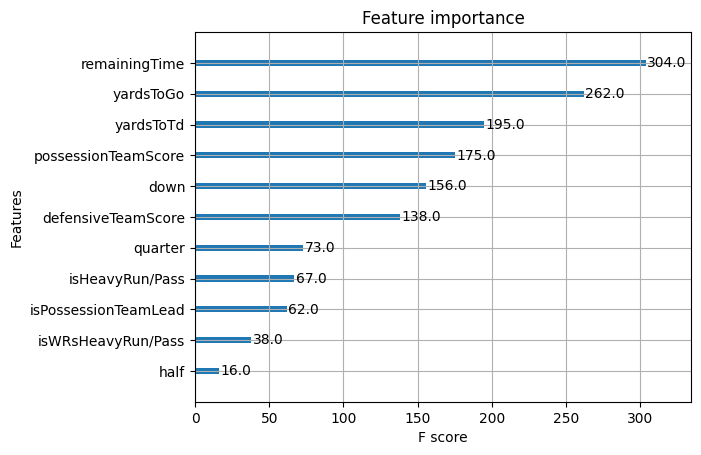

In [24]:
# Plot feature importance
xgb.plot_importance(model)
plt.show()

## Hyperparameters Optimization

In [25]:
def objective(trial):
    params = {
 # Core Parameters
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'max_depth': trial.suggest_int('max_depth', 2, 6),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05),
        
        # Regularization
        'min_child_weight': trial.suggest_int('min_child_weight', 3, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.001, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.001, 1.0, log=True),
        
        # Sampling Parameters
        'subsample': trial.suggest_float('subsample', 0.5, 0.8),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.8),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 0.8),
        
        # Tree Construction
        'max_leaves': trial.suggest_int('max_leaves', 8, 32),
        'min_split_loss': trial.suggest_float('min_split_loss', 0, 10),
        
        
        'random_state': 42,
        'eval_metric': ['logloss', 'error'],
        'early_stopping_rounds': 20
    }
    
    cv_scores_accuracy = []
    cv_scores_logloss = []
    
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Create evaluation set for early stopping
        eval_set = [(X_train, y_train), (X_test, y_test)]

                # Add sample weights based on class distribution
        class_weights = compute_class_weight('balanced', 
                                          classes=np.unique(y_train), 
                                          y=y_train)
        
        sample_weights = np.where(y_train == 1, 
                                class_weights[1], 
                                class_weights[0])        
        
        model = XGBClassifier(**params)
        model.fit(
            X_train, 
            y_train,
            eval_set=eval_set,
            verbose=False
        )
        
        # Get both metrics
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)

        acc = accuracy_score(y_test, y_pred)
        ll = log_loss(y_test, y_pred_proba)
        
        cv_scores_accuracy.append(accuracy_score(y_test, y_pred))
        cv_scores_logloss.append(log_loss(y_test, y_pred_proba))
    
    # Combine metrics (you can adjust weights based on importance)
    mean_accuracy = np.mean(cv_scores_accuracy)
    mean_logloss = np.mean(cv_scores_logloss)
    
    # Return negative logloss (since we want to maximize)
    return 0.7 * mean_accuracy - 0.3 * mean_logloss

# Create study with pruning
pruner = optuna.pruners.MedianPruner(
    n_startup_trials=5,
    n_warmup_steps=5,
    interval_steps=1
)

study = optuna.create_study(
    direction='maximize',
    pruner=pruner,
    sampler=optuna.samplers.TPESampler(n_startup_trials=10, seed=42)
)

# Optimize with more trials
study.optimize(objective, n_trials=400, show_progress_bar=True)

  0%|          | 0/400 [00:00<?, ?it/s]

In [26]:
# Get best parameters
best_params = study.best_params
print('Best parameters:', best_params)

# Create final model with best parameters
best_model = XGBClassifier(**best_params)

# Perform final cross-validation
cv_results = cross_validate(
    best_model,
    X,
    y,
    cv=sss,
    scoring=['accuracy', 'neg_log_loss'],
    return_train_score=True
)

print("\nFinal Cross-validation Results:")
print(f"Train Accuracy: {cv_results['train_accuracy'].mean():.4f} ± {cv_results['train_accuracy'].std():.4f}")
print(f"Test Accuracy: {cv_results['test_accuracy'].mean():.4f} ± {cv_results['test_accuracy'].std():.4f}")
print(f"Train Log Loss: {-cv_results['train_neg_log_loss'].mean():.4f} ± {cv_results['train_neg_log_loss'].std():.4f}")
print(f"Test Log Loss: {-cv_results['test_neg_log_loss'].mean():.4f} ± {cv_results['test_neg_log_loss'].std():.4f}")

Best parameters: {'n_estimators': 239, 'max_depth': 6, 'learning_rate': 0.04858523212506163, 'min_child_weight': 7, 'reg_alpha': 0.08106786837240783, 'reg_lambda': 0.008024183108523314, 'subsample': 0.5987132802754346, 'colsample_bytree': 0.7651968764646102, 'colsample_bylevel': 0.6460244919905014, 'max_leaves': 25, 'min_split_loss': 1.0588529440281198}

Final Cross-validation Results:
Train Accuracy: 0.7699 ± 0.0014
Test Accuracy: 0.7458 ± 0.0017
Train Log Loss: 0.4667 ± 0.0013
Test Log Loss: 0.5121 ± 0.0040


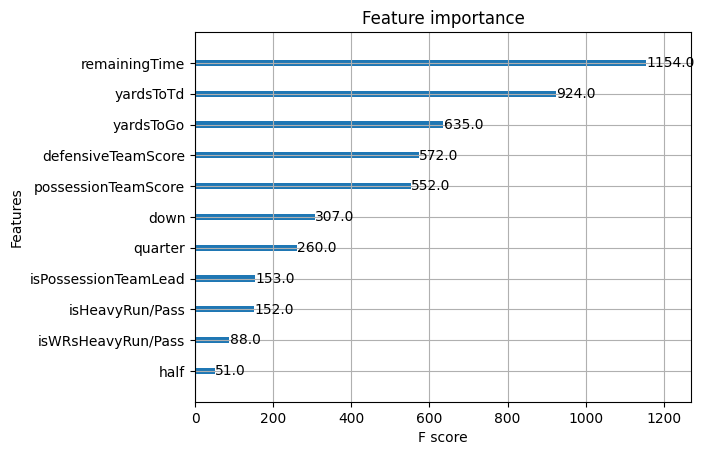

Final Model Accuracy: 0.7463565891472869


In [27]:
# After finding best model
best_model = XGBClassifier(**best_params)
best_model.fit(X_train, y_train)
xgb.plot_importance(best_model)
plt.show()
# Final model predictions and evaluation
y_pred_final = best_model.predict(X_test)
accuracy_final = accuracy_score(y_test, y_pred_final)

print(f'Final Model Accuracy: {accuracy_final}')